In [1]:
import numpy as np
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
from sklearn import linear_model
import time

In [2]:
def make_noisy(x, std=0.001):
    return x + np.random.normal(size=np.shape(x)) * std

In [38]:
def hammer_keypoints_heuristic(point_cloud,
                               n_clusters=12):
    p = np.squeeze(point_cloud)
    center = np.mean(p, axis=0)
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=0).fit(p)
    centers = kmeans.cluster_centers_

    xs, ys, _ = np.split(centers, [1, 2], axis=1)
    ransac = linear_model.RANSACRegressor()
    ransac.fit(xs, np.squeeze(ys))

    centers_inlier = centers[ransac.inlier_mask_]
    grasp_point = random.choice(centers_inlier)
    
    centers_head = centers[
            np.logical_not(ransac.inlier_mask_)]

    if centers_head.shape[0] == 0:
        func_point = random.choice(centers)
    elif centers_head.shape[0] < 3:
        func_point = random.choice(centers_head)
    else:
        hull = ConvexHull(make_noisy(centers_head[:, :2]))
        hull = centers_head[hull.vertices]
        func_point = random.choice(hull)

    grasp_point = np.expand_dims(
        grasp_point, 0).astype(np.float32)
    func_point = np.expand_dims(
        func_point, 0).astype(np.float32)
    
    kmeans = KMeans(
        n_clusters=32,
        random_state=0).fit(p)
    centers_dense = kmeans.cluster_centers_
    hull = ConvexHull(make_noisy(centers_dense[:, :2]))
    hull = centers_dense[hull.vertices]
    hull_index = np.argmin(
            np.linalg.norm(func_point - hull, axis=1))
    func_point = hull[np.newaxis, hull_index]

    vect_grasp_func = np.squeeze(grasp_point - func_point)
    k = vect_grasp_func[1] / (vect_grasp_func[0] + 1e-6)
    
    func_vect = np.reshape(
        np.array([-k/(1 + k**2)**0.5,
                  1/(1 + k**2)**0.5, 0.0]), [1, 3])
    vect_center_func = func_point - center
    if vect_center_func.dot(func_vect.T) < 0:
        func_vect = -func_vect

    grasp_point = grasp_point.astype(np.float32)
    func_point = func_point.astype(np.float32)
    func_vect = func_vect.astype(np.float32)

    
    if True:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)
        ax.scatter(p[:, 0], p[:, 1], c='green', s=0.1, alpha=0.3)
        ax.scatter(
            func_point[0, 0], func_point[0, 1], c='green', s=10)
        ax.scatter(
            [func_point[0, 0] + func_vect[0, 0] * 0.1], [func_point[0, 1] + func_vect[0, 1] * 0.1], c='green', s=10)
        ax.scatter(
            grasp_point[0, 0], grasp_point[0, 1], c='red', s=10)
        plt.xlim((0.4, 1.0))
        plt.ylim((-0.5, 0.1))
        plt.show()


In [45]:
point_cloud = np.load(open('../../episodes/hammer_point_cloud_second/point_cloud/950112_000003.npy', 'rb'))

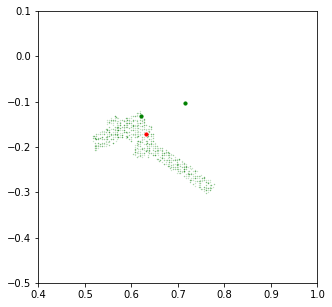

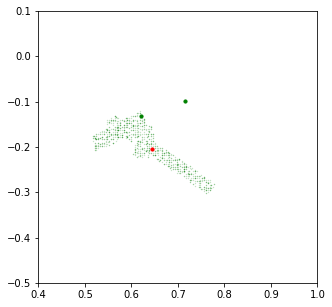

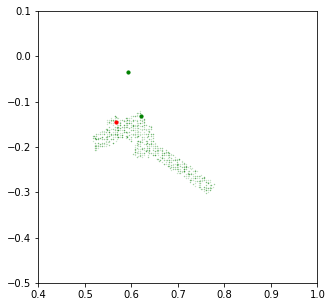

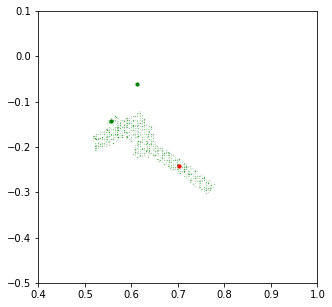

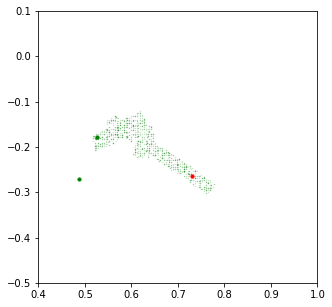

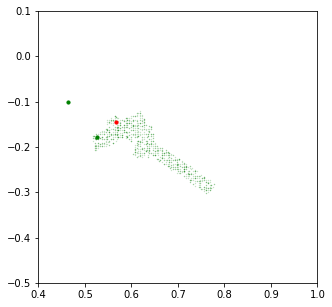

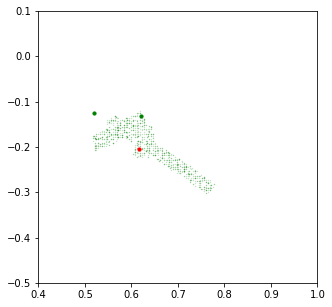

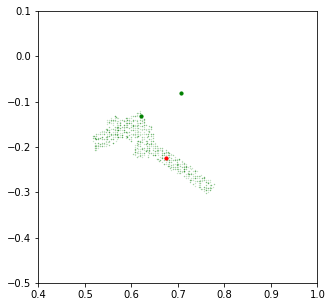

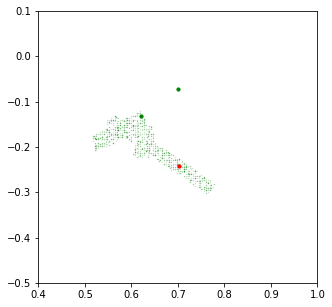

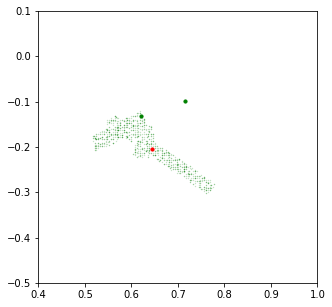

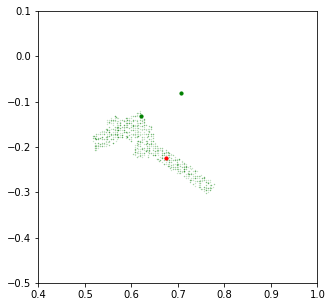

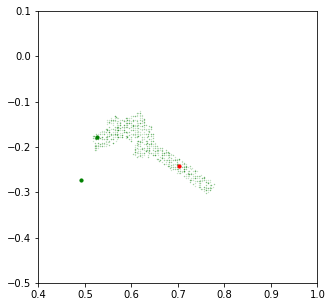

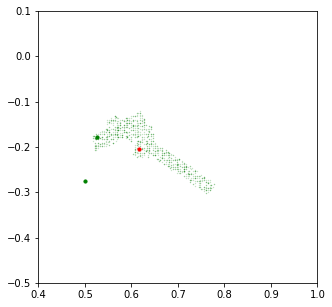

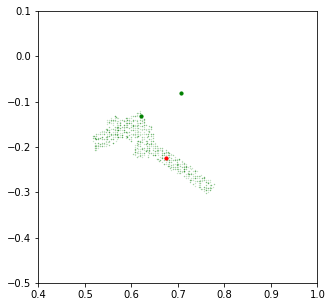

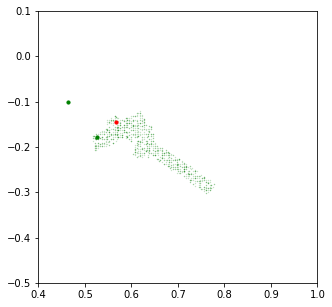

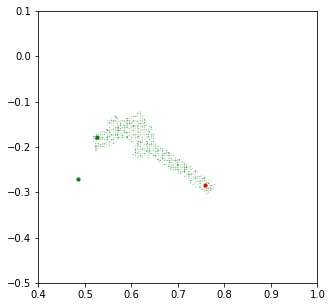

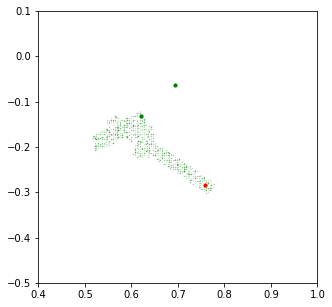

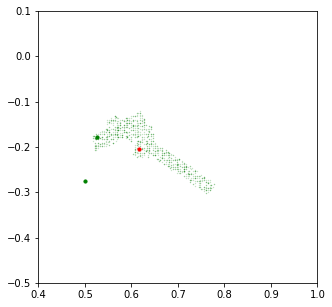

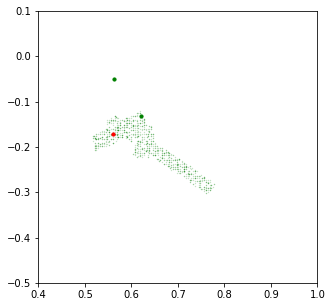

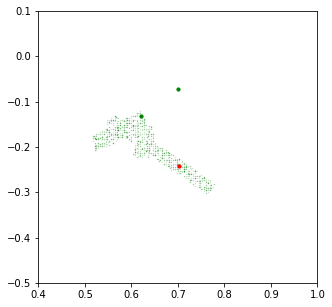

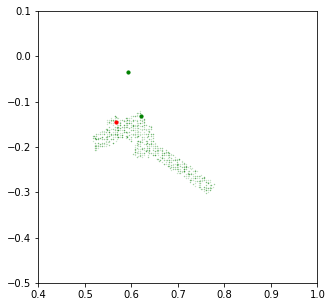

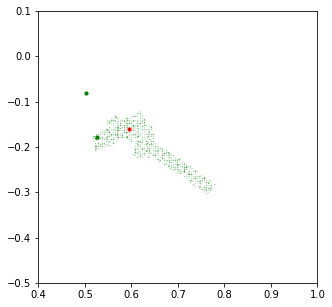

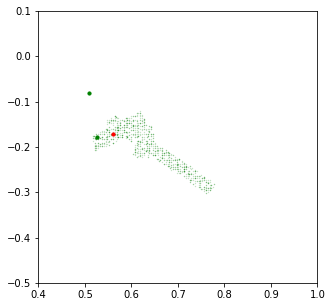

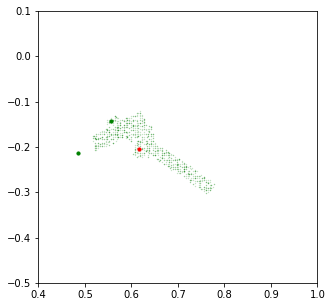

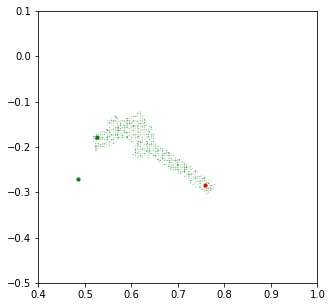

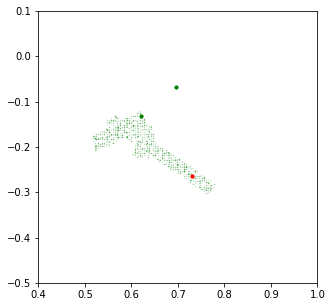

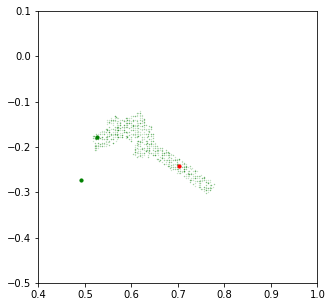

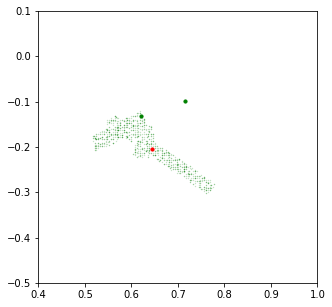

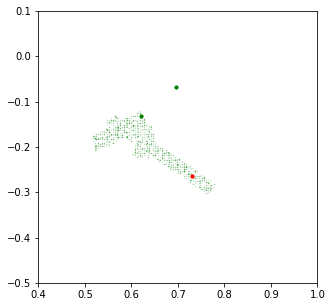

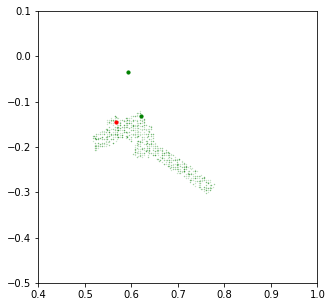

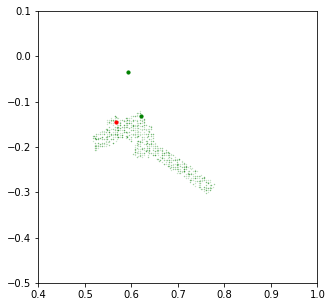

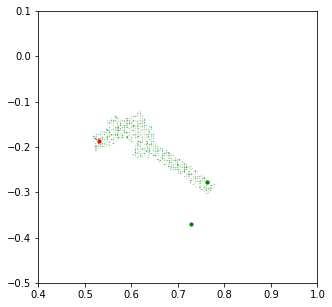

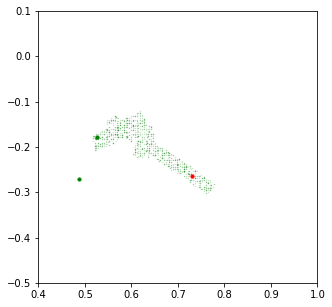

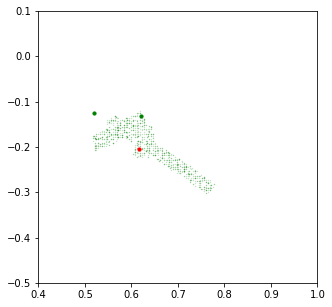

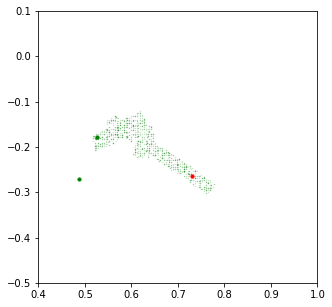

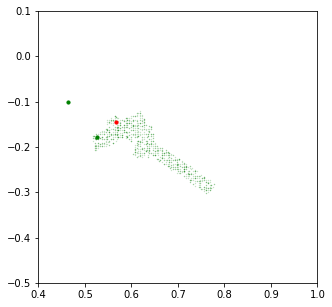

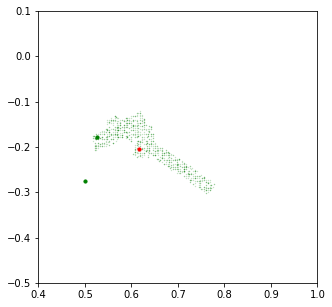

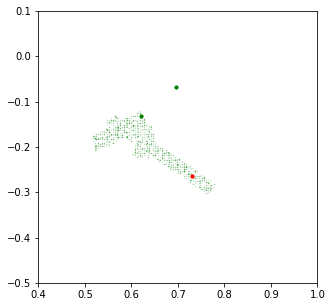

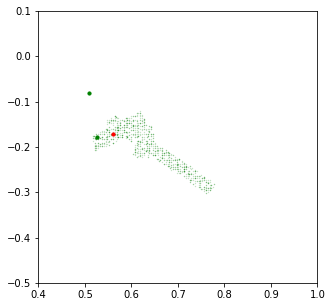

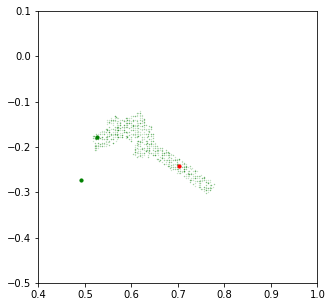

0.3696296393871307


In [46]:
start = time.time()
for _ in range(40):
    hammer_keypoints_heuristic(point_cloud)
    
end = time.time()
print((end-start)/40)